# Mineração de Texto e Web - Projeto: Construção de um Sistema de Monitoramento de Reviews

### Alunas:
- **Laianna Lana Virginio da Silva** - *llvs2@cin.ufpe.br*
- **Liviany Reis Rodrigues** - *lrr@cin.ufpe.br*

# Informações do Projeto

### Link do GitHub:
- https://github.com/Laianna/projeto-mineracao-texto-web

### Produto a Ser Monitorado:
- Smartwatch Xiaomi Mi Band 4 Oled Preto

### Fonte de Dados:
- https://www.amazon.com.br/Smartwatch-Xiaomi-Preto-Original-Lacrado/dp/B07SNG23JW/ref=cm_cr_arp_d_product_top?ie=UTF8

# Bibliotecas

In [1]:
#####################################################################

import pandas as pd
import numpy as np

#####################################################################

from tqdm import tqdm
tqdm.pandas()

#####################################################################

from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

#####################################################################

from gensim.models import Word2Vec

#####################################################################

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

#####################################################################

import torch

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision.transforms as transforms

from torch.utils.data.dataloader import DataLoader

#####################################################################

import nltk
from nltk.stem import SnowballStemmer

#####################################################################

#SPACY
import spacy

#####################################################################

import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

#####################################################################

In [4]:
SEED = 42

In [2]:
# force CPU (make CPU visible)
cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)
tf.config.set_visible_devices([], 'GPU')  # hide the GPU
tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Base de Dados

## Carregamento dos Dados

In [5]:
df = pd.read_csv("Dados/avaliações.csv", parse_dates = ["Data"])
df.head(1)

,Review,Estrela,Data
0,No anúncio informa que a pulseira é a versão g...,1,2019-07-17


## Checando Dados Duplicados

In [6]:
df.duplicated().any()

True

Resultado deu *True*. Logo, não existem dados duplicados.

## Checando as Informações

In [7]:
print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")

Linhas: 7138, Colunas: 3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7138 entries, 0 to 7137
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Review   7138 non-null   object        
 1   Estrela  7138 non-null   int64         
 2   Data     7138 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 167.4+ KB


In [9]:
df["Estrela"].value_counts()

5    6154
4     593
1     237
3     102
2      52
Name: Estrela, dtype: int64

In [10]:
df["Data"].dt.year.value_counts()

2020    4253
2019    2343
2021     507
2022      35
Name: Data, dtype: int64

Lembrando que o produto foi lançado no meio de 2019.

## Formatando os Tipos

In [11]:
df.dtypes

Review             object
Estrela             int64
Data       datetime64[ns]
dtype: object

In [12]:
df["Review"] = df["Review"].astype("string")

In [13]:
df.dtypes

Review             string
Estrela             int64
Data       datetime64[ns]
dtype: object

# Pré-Processamento da Classe

**Recodificando a coluna "Estrela" para *Negativo* e *Positivo*:**

- **Negativo:** 1 ★ 2 ★ 3 ★

- **Positivo:** 4 ★ 5 ★

In [14]:
def recodificar_classe(estrela):

    if estrela == 4 or estrela == 5:
        return 1 # positivo
    else:
        return 0 # negativo

In [15]:
df["classe"] = df["Estrela"].apply(lambda estrela: recodificar_classe(estrela))

In [16]:
df["classe"].value_counts()

1    6747
0     391
Name: classe, dtype: int64

O dataset está muito desbalanceado.

In [17]:
df["classe"].value_counts(normalize = True)

1    0.945223
0    0.054777
Name: classe, dtype: float64

94.52% do dataset contém reviews positivas e 5.48% negativas.

# Pré-Processamento do Texto

## Tokenização

Abaixo fizemos o processo de tokenização sem nenhum tipo de pré-processamento além de caixa baixa. Lembrando que na 
[`definição do projeto`](https://github.com/ProfLuciano/mineracao_texto/blob/main/slides/intro.pdf)
é pedido apenas com e sem stemming. Os outros tipos de pré-processamento (remoção de pontuação, palavras vazias, caixa baixa,  lematização, etc) ficaram apenas como adicional para quem desejar.

In [18]:
df["tokenizacao"] = df.apply(lambda linha: nltk.word_tokenize(linha["Review"].lower(), language = 'portuguese'), axis = 1)

In [20]:
# tamanho máximo das reviews na base de dados sem nenhum pré-processamento
max(df.apply(lambda row: len(row['tokenizacao']), axis = 1))

637

## Stemming

Para fazer o stemming vamos usar o [`SnowballStemmer`](https://www.nltk.org/api/nltk.stem.snowball.html) da biblioteca NLTK, indicando que o idioma do texto está em português.

In [21]:
def aplicando_stemming(texto):
    
    stemmer = SnowballStemmer('portuguese')
    texto_stemming = [stemmer.stem(palavra) for palavra in texto]
    
    #return texto_stemming
    return " ".join(texto_stemming)

In [22]:
df["stemming"] = df["tokenizacao"].apply(lambda linha: aplicando_stemming(linha))
df["stemming_tkn"] = df.apply(lambda linha: nltk.word_tokenize(linha["stemming"], language = 'portuguese'), axis = 1)
df[["tokenizacao", "stemming", "stemming_tkn"]].head(5)

,tokenizacao,stemming,stemming_tkn
0,"[no, anúncio, informa, que, a, pulseira, é, a,...",no anúnci inform que a pulseir é a versã globa...,"[no, anúnci, inform, que, a, pulseir, é, a, ve..."
1,"[realizei, a, compra, de, 2, duas, mi, band, 4...",realiz a compr de 2 duas mi band 4 pel port st...,"[realiz, a, compr, de, 2, duas, mi, band, 4, p..."
2,"[comprei, 2, mi, bands, ,, não, tem, nem, 1, s...","compr 2 mi bands , nã tem nem 1 seman . a bat ...","[compr, 2, mi, bands, ,, nã, tem, nem, 1, sema..."
3,"[anúncio, enganoso, ,, a, pulseira, é, na, ver...","anúnci engan , a pulseir é na versã chines , n...","[anúnci, engan, ,, a, pulseir, é, na, versã, c..."
4,"[produto, com, defeito, ., efetuei, a, devoluç...","produt com defeit . efetu a devolu , assum o c...","[produt, com, defeit, ., efetu, a, devolu, ,, ..."


Note que o texto depois de passar pelo SnowballStemmer é retornado em caixa baixa.

In [23]:
# tamanho máximo das reviews na base de dados usando stemming
max(df.apply(lambda row: len(row["stemming_tkn"]), axis = 1))

637

# Separando o Dataset em Treino e Teste

In [24]:
test_size_1 = 0.20
test_size_2 = 0.30

In [25]:
y = df["classe"]

## Dados Pré-Processados Sem Stemming

In [26]:
X = df["tokenizacao"]

In [27]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = test_size_1, random_state = SEED, stratify = y)
X_treino, X_valid, y_treino, y_valid = train_test_split(X_treino, y_treino, test_size = test_size_2, random_state = SEED, stratify = y_treino)

## Dados Pré-Processados Com Stemming

In [28]:
X_treino_stem = df["stemming_tkn"][X_treino.index.tolist()]
X_valid_stem = df["stemming_tkn"][X_valid.index.tolist()]
X_teste_stem = df["stemming_tkn"][X_teste.index.tolist()]

y_treino_stem = df["classe"][y_treino.index.tolist()]
y_valid_stem = df["classe"][y_valid.index.tolist()]
y_teste_stem = df["classe"][y_teste.index.tolist()]

## Checando os tamanhos

In [29]:
len(X_treino)

3997

In [30]:
y_treino.value_counts()

1    3778
0     219
Name: classe, dtype: int64

In [31]:
len(X_valid)

1713

In [32]:
y_valid.value_counts()

1    1619
0      94
Name: classe, dtype: int64

In [33]:
len(X_teste)

1428

In [34]:
y_teste.value_counts()

1    1350
0      78
Name: classe, dtype: int64

# Random Forest com Bag of Words

Vamos pegar apenas as N (por padrão 1000) palavras mais frequentes no vocabulário para prosseguir com a análise.
Para isso, definimos o parâmetro "*max_features*" quando chamamos o CountVectorizer e geramos uma matriz com as N palavras mais frequentes. Cada linha da matriz indica a presença ou ausência das palavras (agora colunas na matriz) na Review.
Depois disso, usamos o Random Forest para predizer a classe. Por fim, exibimos o *F1*, a *precisão* e o *recall* com o Relatório de classificação.

In [35]:
def relatorio(y, y_pred, digitos = 4):
    
    print('Relatório de classificação:\n', classification_report(y, y_pred, digits = digitos, target_names = ["Negativo", "Positivo"], zero_division = 1))

In [36]:
def matriz_de_confusao(y, y_pred):

    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    
    sns.heatmap(cm, annot = True,
                xticklabels = ['Falso', 'Verdadeiro'],
                yticklabels = ['Falso', 'Verdadeiro'],
                fmt = "d", cbar = False)

    ax.set_title('Matriz de Confusão')    
    fig.set_size_inches(5, 5)

In [37]:
def relatorio_matriz(y, y_pred, digitos = 4):
    
    relatorio(y, y_pred, digitos)
    matriz_de_confusao(y, y_pred)    

In [38]:
def rf(X, y):
    
    classificador = RandomForestClassifier()
    classificador.fit(X, y)
    
    return classificador

In [120]:
def formatar_entrada_rf_bow(dados, mf = 1000):
    
    matriz = CountVectorizer(max_features = mf)
    X = matriz.fit_transform(dados).toarray()
    
    return X

In [121]:
def rf_bow(dados, classe, mf = 1000):
    
    X = formatar_entrada_rf_bow(dados, mf)
    y = classe
    
    classificador = rf(X, y)

    #print(len(matriz.get_feature_names_out()))    
    
    return classificador

In [123]:
mf = 1700

### Sem Pré-Processamento de Texto

In [124]:
classificador = rf_bow(dados = df['Review'][X_treino.index.tolist()], classe = df['classe'][y_treino.index.tolist()], mf = mf)

In [125]:
y_pred_rf_bow_tkn = classificador.predict(formatar_entrada_rf_bow(df['Review'][X_teste.index.tolist()], mf))

Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     0.2083    0.1282    0.1587        78
    Positivo     0.9507    0.9719    0.9612      1350

    accuracy                         0.9258      1428
   macro avg     0.5795    0.5500    0.5600      1428
weighted avg     0.9102    0.9258    0.9173      1428



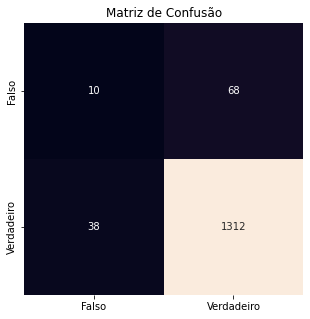

In [126]:
relatorio_matriz(df['classe'][y_teste.index.tolist()], y_pred_rf_bow_tkn)

### Com Stemming

In [127]:
classificador = rf_bow(dados = df["stemming"][X_treino_stem.index.tolist()], classe = df['classe'][y_treino_stem.index.tolist()], mf = mf)

In [128]:
y_pred_rf_bow_stem = classificador.predict(formatar_entrada_rf_bow(df["stemming"][X_teste_stem.index.tolist()], mf))

Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     0.1071    0.1538    0.1263        78
    Positivo     0.9498    0.9259    0.9377      1350

    accuracy                         0.8838      1428
   macro avg     0.5285    0.5399    0.5320      1428
weighted avg     0.9038    0.8838    0.8934      1428



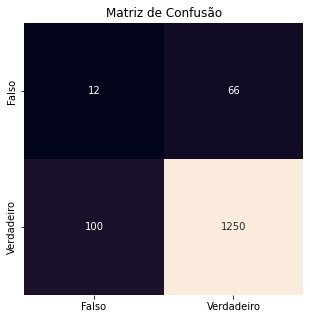

In [129]:
relatorio_matriz(df['classe'][y_teste_stem.index.tolist()], y_pred_rf_bow_stem)

O resultado do Classificador Random Forest com Bag of Words não foi muito bom...

Lembrando que o modelo muda de acordo com a variação no parâmetro *max_features*.

# Redes Neurais

## Treinamento do Modelo

Treinamos o modelo usando o Word2Vec com todos os tokens que aparecem nas reviews.

Vale lembrar que como o modelo vai ser treinando usando todos os tokens, então mais para frente a gente não vai precisar fazer a verificação se a palavra encontra-se ou não no dicionário. Se nós tivéssemos pego um modelo pronto ou caso fôssemos utilizar esse modelo treinado por nós para outro dataset, era necessário fazer a verificação das palavras no dicionário.

### Sem Pré-Processamento do Texto

In [50]:
modelo_w2v_tkn = Word2Vec(df["tokenizacao"], vector_size = 100, window = 5, min_count = 1, workers = 4)

In [51]:
tam_vocab_w2v_tkn = modelo_w2v_tkn.wv.vectors.shape
tam_vocab_w2v_tkn

(6443, 100)

### Com Stemming

In [52]:
modelo_w2v_stem = Word2Vec(df["stemming_tkn"], vector_size = 100, window = 5, min_count = 1, workers = 4)

In [53]:
tam_vocab_w2v_stem = modelo_w2v_stem.wv.vectors.shape
tam_vocab_w2v_stem

(3933, 100)

### Checando os modelos

Vamos checar nos dois modelos quais palavras são mais similares a palavra *bom*

In [54]:
modelo_w2v_tkn.wv.most_similar(positive = 'bom')

[('excelente', 0.955264151096344),
 ('ótimo', 0.9533548355102539),
 ('gostei', 0.9311394691467285),
 ('funcional', 0.9275509119033813),
 ('bonito', 0.9215478301048279),
 ('bacana', 0.9193645119667053),
 ('resumindo', 0.9191482663154602),
 ('eficiente', 0.9178067445755005),
 ('lindo', 0.9160403609275818),
 ('aparentemente', 0.9152727723121643)]

In [55]:
modelo_w2v_stem.wv.most_similar(positive = 'bom')

[('excelent', 0.9344902038574219),
 ('ótim', 0.9333053231239319),
 ('bonit', 0.9273422360420227),
 ('gost', 0.916689932346344),
 ('material', 0.9156326651573181),
 ('confort', 0.911762535572052),
 ('qualidad', 0.9116054773330688),
 ('lind', 0.9063152074813843),
 ('recom', 0.9029057025909424),
 ('custo/benefíci', 0.8945326805114746)]

Os dois modelos aparecem com as palavras *execelente*, *ótimo*, *gostei*, *bonito* e *lindo* no top 10 semelhança com a palavra *bom*.

### Checando o Tamanho das Entradas

Vamos checar qual o tamanho máximo dos tokens na base de dados e também olhar o histograma para ver como se comporta a distribuição da quantidade de tokens por frase.

637


<AxesSubplot:>

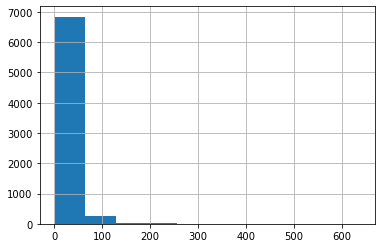

In [56]:
tam = df['tokenizacao'].apply(len)

print(np.max(tam))

tam.hist()

In [57]:
corte = int(np.percentile(tam.values, 97))
corte

74

Com isso descobrimos que 97% das avaliações tem no máximo 74 tokens. Vamos usar esse valor a seguir para delimitar a quantidade de tokens por frase que iremos usar.

## Padronizando a Entrada

Como os reviews possuem tamanhos diferentes, vamos padronizar o tamanho usando padding e vamos substituir os tokens pela representação deles no modelo treinado anteriormente com o Word2Vec.

A gente usa a variável *num_max_tokens* para delimitar a quantidade máxima de tokens a serem utilizados. O padrão da função é 637 que é a quantidade máxima de tokens nas reviews, ou seja, sem aplicar nenhum tipo de pré-processamento além da caixa baixa, mas nós não vamos usar esse valor padrão.

In [58]:
def formatar_entrada(tokens, modelo, num_max_tokens = 637):

    entrada = np.zeros((num_max_tokens, modelo.vector_size))

    for i in range(len(tokens)):
        if i < num_max_tokens:
            entrada[i] = modelo.wv[str(tokens[i])]

    return entrada

Vamos trunkar a quantidade de tokens na entrada de acordo com a variável *corte*, visto que, essa variável leva em conta o tamanho máximo de tokens de todas as reviews da base de dados.

É melhor trunkar os tokens de acordo com o tamanho da maioria do que adicionar um *padding* enorme por causa de poucas reviews longas. Afinal, adicionar muito padding pode interferir no resultado.

### Sem Pré-Processamento

In [59]:
entrada_treino_tkn = X_treino.apply(lambda linha: formatar_entrada(linha, modelo_w2v_tkn, corte))
entrada_teste_tkn  =  X_teste.apply(lambda linha: formatar_entrada(linha, modelo_w2v_tkn, corte))
entrada_valid_tkn  =  X_valid.apply(lambda linha: formatar_entrada(linha, modelo_w2v_tkn, corte))

### Com Stemming

In [60]:
entrada_treino_stem = X_treino_stem.apply(lambda linha: formatar_entrada(linha, modelo_w2v_stem, corte))
entrada_teste_stem  =  X_teste_stem.apply(lambda linha: formatar_entrada(linha, modelo_w2v_stem, corte))
entrada_valid_stem  =  X_valid_stem.apply(lambda linha: formatar_entrada(linha, modelo_w2v_stem, corte))

## Definindo o DataLoader

Define o DataLoader utilizando os dados já separados em treino, teste e validação.

É necessário dropar o último batch quando vamos montar o DataLoader pois ele tem um tamanho menor que os outros. Devido a isso, o último batch causa um problema de dimensionamento do hidden state e cell state do LSTM.

In [61]:
tam_batch = 32

In [62]:
def criando_data_loader(X, y, tam_batch = 32):
    
    X_ = np.asarray(X.to_list(), dtype = np.float32)
    y_ = np.asarray(y).astype('float32').reshape(-1)
    
    X_loader = DataLoader(X_, batch_size = tam_batch, shuffle = True, drop_last = True)
    y_loader = DataLoader(y_, batch_size = tam_batch, shuffle = True, drop_last = True)
    
    return X_loader, y_loader

### Sem Pré-Processamento

In [63]:
X_treino_loader_tkn, y_treino_loader_tkn = criando_data_loader(entrada_treino_tkn, y_treino)
X_teste_loader_tkn,  y_teste_loader_tkn  = criando_data_loader(entrada_teste_tkn,  y_teste)
X_valid_loader_tkn,  y_valid_loader_tkn  = criando_data_loader(entrada_valid_tkn,  y_valid)

### Com Stemming

In [64]:
X_treino_loader_stem, y_treino_loader_stem = criando_data_loader(entrada_treino_stem, y_treino_stem)
X_teste_loader_stem,  y_teste_loader_stem  = criando_data_loader(entrada_teste_stem,  y_teste_stem)
X_valid_loader_stem,  y_valid_loader_stem  = criando_data_loader(entrada_valid_stem,  y_valid_stem)

## Funções de Treinamento e Validação

Abaixo vamor definir as funções de treinamento e validação que serão usadas na CNN e na LSTM.

As funções foram separadas pois a LSTM precisa da manipulação do hidden state e cell state (que chamamos de *h* no código abaixo).

### CNN

#### Função para Treinamento

In [65]:
def treinamento_cnn(X_treino_loader, y_treino_loader, modelo, criterio, otimizador, epoca):

    perda_treino = 0
    
    #print("Iniciando o Treinamento da época {epoca}")  
    
    modelo.train()

    for i, (x, y) in enumerate(zip(X_treino_loader, y_treino_loader)):

        # move os tensores para GPU, se aplicável
        if usar_gpu == True:
            x = x.cuda()
            y = y.cuda()
            
        # Zera o gradiente de todas as variávels do otimizador 
        otimizador.zero_grad()

        # Faz um forward no modelo passando x como entrada
        y_pred = modelo(x)
        
        # Calcula a loss do batch
        perda = criterio(y, y_pred)

        # Computa o gradiente (backward na loss)
        perda.backward()

        # Otimização
        otimizador.step()
        
        # Atualização da loss de treinamento
        perda_treino += perda

    perda_treino = perda_treino/len(X_treino_loader.dataset)
    print(f"Epoca {epoca + 1} \t Loss de Treinamento: {perda_treino}")
    
    #print(f"Terminando o treinamendo da época {epoca}")

#### Função para Validação

In [66]:
def validacao_cnn(X_valid_loader, y_valid_loader, modelo, criterio, epoca):
    
    perda_valid = 0
    
    #print("Iniciando a validação da época {epoca}")      
    
    modelo.eval()

    for i, (x, y) in enumerate(zip(X_valid_loader, y_valid_loader)):
        
        # move os tensores para GPU, se aplicável
        if usar_gpu == True:
            x = x.cuda()
            y = y.cuda()
            
        # Faz um forward no modelo passando x como entrada
        y_pred = modelo(x)

        # Calcula a loss do batch
        perda = criterio(y, y_pred)
        
        # Atualização da loss de treinamento
        perda_valid += perda

    perda_valid = perda_valid/len(X_valid_loader.dataset)
    print(f"Epoca {epoca + 1} \t Loss de Validação: {perda_valid}")
        
    #print(f"Terminando a validação da época {epoca}")
    
    return perda_valid

#### Função que Treina e Valida

In [67]:
def treinamento_validacao_cnn(X_treino_loader, y_treino_loader,
                              X_valid_loader, y_valid_loader, 
                              modelo_cnn, criterio, otimizador, n_epocas):

    # Treinamento e Validação
    menor_perda = 1e10
    for epoca in range(n_epocas):

        # Treina por uma época e depois valida
        treinamento_cnn(X_treino_loader, y_treino_loader, modelo_cnn, criterio, otimizador, epoca)

        with torch.no_grad():
            perda = validacao_cnn(X_valid_loader, y_valid_loader, modelo_cnn, criterio, epoca)

        # Salva se o modelo atual for melhor
        if perda < menor_perda:
            menor_perda = perda
            torch.save(modelo_cnn.state_dict(), 'Checkpoints/CNN/modelo-epoca-{}-perda-{:.4f}.pth'.format(epoca+1,perda))

        print("")

#### Função de Teste

In [68]:
def teste_cnn(X_teste_loader, y_teste_loader, modelo):
    
    y_pred_teste = []

    for i, (x, y) in enumerate(zip(X_teste_loader, y_teste_loader)):

        # move os tensores para GPU, se aplicável
        if usar_gpu == True:
            x = x.cuda()
            y = y.cuda()        
            y_pred = modelo(x).cpu().detach().numpy()

        else:
            y_pred = modelo(x).detach().numpy()

        y_pred_teste = y_pred_teste + formatar_classe_predita(y_pred)
        
    return y_pred_teste

### LSTM

#### Função para Treinamento

In [69]:
def treinamento_lstm(X_treino_loader, y_treino_loader, modelo, criterio, otimizador, epoca):
    
    # dependendo se a lstm for bidirecional ou não, vai ser iniciado o hidden state com tamanho diferente    
    if flag_bidirecional == True:
        h = modelo.iniciar_tensor_hidden(tam_batch*2)
    else:
        h = modelo.iniciar_tensor_hidden(tam_batch)
    
    perda_treino = 0
    
    #print("Iniciando o Treinamento da época {epoca}")  
    
    modelo.train()

    for i, (x, y) in enumerate(zip(X_treino_loader, y_treino_loader)):

        # move os tensores para GPU, se aplicável
        if usar_gpu == True:
            x = x.cuda()
            y = y.cuda()
            
        h = tuple([each.data for each in h])
            
        # Zera o gradiente de todas as variávels do otimizador 
        otimizador.zero_grad()

        # Faz um forward no modelo passando x como entrada
        y_pred, h = modelo(x, h)
        
        # Calcula a loss do batch
        perda = criterio(y, y_pred)

        # Computa o gradiente (backward na loss)
        perda.backward()

        # Otimização
        otimizador.step()
        
        # Atualização da loss de treinamento
        perda_treino += perda

    perda_treino = perda_treino/len(X_treino_loader.dataset)
    print(f"Epoca {epoca + 1} \t Loss de Treinamento: {perda_treino}")
    
    #print(f"Terminando o treinamendo da época {epoca}")

#### Função para Validação

In [70]:
def validacao_lstm(X_valid_loader, y_valid_loader, modelo, criterio, epoca):
    
    # dependendo se a lstm for bidirecional ou não, vai ser iniciado o hidden state com tamanho diferente
    if flag_bidirecional == True:
        val_h = modelo.iniciar_tensor_hidden(tam_batch*2)
    else:
        val_h = modelo.iniciar_tensor_hidden(tam_batch)

    perda_valid = 0
    
    #print("Iniciando a validação da época {epoca}")      
    
    modelo.eval()

    for i, (x, y) in enumerate(zip(X_valid_loader, y_valid_loader)):
        
        # move os tensores para GPU, se aplicável
        if usar_gpu == True:
            x = x.cuda()
            y = y.cuda()
            
        val_h = tuple([each.data for each in val_h])
            
        # Faz um forward no modelo passando x como entrada
        y_pred, val_h = modelo(x, val_h)

        # Calcula a loss do batch
        perda = criterio(y, y_pred)
        
        # Atualização da loss de treinamento
        perda_valid += perda

    perda_valid = perda_valid/len(X_valid_loader.dataset)
    print(f"Epoca {epoca + 1} \t Loss de Validação: {perda_valid}")
        
    #print(f"Terminando a validação da época {epoca}")
    
    return perda_valid

#### Função que Treina e Valida

In [71]:
def treinamento_validacao_lstm(X_treino_loader, y_treino_loader,
                               X_valid_loader, y_valid_loader,
                               modelo_lstm, criterio, otimizador, n_epocas):
    
    # Treinamento e Validação
    menor_perda = 1e10
    for epoca in range(n_epocas):

        # Treina por uma época e depois valida
        treinamento_lstm(X_treino_loader, y_treino_loader, modelo_lstm, criterio, otimizador, epoca)    
        with torch.no_grad():
            perda = validacao_lstm(X_valid_loader, y_valid_loader, modelo_lstm, criterio, epoca)

        # Salva se o modelo atual for melhor
        if perda < menor_perda:
            menor_perda = perda
            torch.save(modelo_lstm.state_dict(), 'Checkpoints/LSTM/modelo-epoca-{}-perda-{:.4f}.pth'.format(epoca+1,perda))

        print("")

#### Função de Teste

In [72]:
def teste_lstm(X_teste_loader, y_teste_loader, modelo):
    
    h = modelo.iniciar_tensor_hidden(tam_batch)
    h = tuple([dado.data for dado in h])

    y_pred_teste = []

    for i, (x, y) in enumerate(zip(X_teste_loader, y_teste_loader)):
        
        # move os tensores para GPU, se aplicável
        if usar_gpu == True:
            x = x.cuda()
            y = y.cuda()

            y_pred, h = modelo(x, h)
            y_pred = y_pred.cpu().detach().numpy()

        else:
            y_pred, h = modelo(x, h)
            y_pred = y_pred.detach().numpy()
            

        y_pred_teste = y_pred_teste + formatar_classe_predita(y_pred)
        
    return y_pred_teste

### Função Auxiliar

Função auxiliar para formatar os dados.

In [73]:
def formatar_classe_predita(array):

    lista = array.flatten().tolist()
    
    lista = [int(round(num)) for num in lista]
    
    return lista

## Checando se o CUDA está disponível

In [74]:
usar_gpu = torch.cuda.is_available()

if usar_gpu == True:
  print("CUDA disponível (✯◡✯) Processamento em GPU!")
else:
  print("CUDA NÃO disponível (ಥ﹏ಥ) Processamento em CPU!")

CUDA disponível (✯◡✯) Processamento em GPU!


## Flags de Controle

Variavéis de controle para saber quais redes neurais queremos rodar.

In [75]:
flag_cnn = True
flag_lstm = True
flag_bert = True

## Rede Neural Convolucional (CNN)

### Definição do Modelo

In [315]:
class CnnAnaliseSentimento(nn.Module):

    def __init__(self, tam_max):

        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv1d(in_channels = tam_max, out_channels = 35, kernel_size = 100, stride = 2),
                                   nn.Dropout(0.5),
                                   nn.ReLU(True),
                                  )
        
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels = 35, out_channels = 10, kernel_size = 1, stride = 5),
                                        nn.Dropout(0.4),
                                        nn.ReLU(True)
                                       )

        self.conv3 = nn.Sequential(nn.Conv1d(in_channels = 10, out_channels = 1, kernel_size = 1),
                                   nn.Sigmoid()
                                   )


    def forward(self, x):

        x_conv1 = self.conv1(x)
        x_conv1 = F.max_pool1d(x_conv1, x_conv1.size(2))
        
        x_conv2 = self.conv2(x_conv1)
        x_conv2 = F.max_pool1d(x_conv2, x_conv2.size(2))

        x_conv3 = self.conv3(x_conv2)
        x_conv3 = x_conv3.flatten()

        return torch.round(x_conv3)

### Alocação do modelo e device adequado (dependente da disponibilidade da GPU)

In [316]:
# cria o modelo
modelo_cnn_tkn = CnnAnaliseSentimento(corte)
modelo_cnn_stem = CnnAnaliseSentimento(corte)

# joga o modelo para GPU, caso aplicável
if usar_gpu == True:
    torch.cuda.init()
    cudnn.benchmark = True
    device = torch.device("cuda")
    modelo_cnn_tkn.cuda()
    modelo_cnn_stem.cuda()
else:
    device = torch.device("cpu")

In [317]:
print(modelo_cnn_tkn)

CnnAnaliseSentimento(
  (conv1): Sequential(
    (0): Conv1d(74, 35, kernel_size=(100,), stride=(2,))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(35, 10, kernel_size=(1,), stride=(5,))
    (1): Dropout(p=0.4, inplace=False)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv1d(10, 1, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
)


### Função de Custo e Otimizador

In [318]:
# função de custo (loss) adequada
criterio = nn.MSELoss()

# otimizador
otimizador_tkn  = torch.optim.Adam(modelo_cnn_tkn.parameters(), lr = 0.001)
otimizador_stem = torch.optim.Adam(modelo_cnn_stem.parameters(), lr = 0.001)

### Treinamento e Validação

In [319]:
# definição do numero de épocas
n_epocas = 5

#### Sem Pré-Processamento

In [320]:
treinamento_validacao_cnn(X_treino_loader_tkn, y_treino_loader_tkn,
                          X_valid_loader_tkn, y_valid_loader_tkn,
                          modelo_cnn_tkn, criterio, otimizador_tkn, n_epocas)

Epoca 1 	 Loss de Treinamento: 0.0017669502412900329
Epoca 1 	 Loss de Validação: 0.0017148277256637812

Epoca 2 	 Loss de Treinamento: 0.0017982237040996552
Epoca 2 	 Loss de Validação: 0.0017148277256637812

Epoca 3 	 Loss de Treinamento: 0.0017434951150789857
Epoca 3 	 Loss de Validação: 0.0016965848626568913

Epoca 4 	 Loss de Treinamento: 0.0017982237040996552
Epoca 4 	 Loss de Validação: 0.0016965848626568913

Epoca 5 	 Loss de Treinamento: 0.00179040536750108
Epoca 5 	 Loss de Validação: 0.0016965848626568913



##### Carregando o melhor modelo

In [338]:
melhor_modelo_tkn = torch.load('Checkpoints/CNN/modelo-epoca-3-perda-0.0017.pth', map_location = lambda storage, loc: storage)
modelo_cnn_tkn.load_state_dict(melhor_modelo_tkn)

<All keys matched successfully>

##### Teste

Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     1.0000    0.0000    0.0000        77
    Positivo     0.9453    1.0000    0.9719      1331

    accuracy                         0.9453      1408
   macro avg     0.9727    0.5000    0.4859      1408
weighted avg     0.9483    0.9453    0.9187      1408



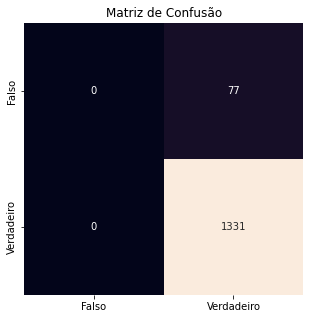

In [339]:
y_pred_teste_cnn_tkn = teste_cnn(X_teste_loader_tkn, y_teste_loader_tkn, modelo_cnn_tkn)
relatorio_matriz(y_teste.tolist()[:len(y_pred_teste_cnn_tkn)], y_pred_teste_cnn_tkn)

#### Com Stemming

In [328]:
treinamento_validacao_cnn(X_treino_loader_stem, y_treino_loader_stem,
                          X_valid_loader_stem, y_valid_loader_stem,
                          modelo_cnn_stem, criterio, otimizador_stem, n_epocas)

Epoca 1 	 Loss de Treinamento: 0.02931886538863182
Epoca 1 	 Loss de Validação: 0.029261529445648193

Epoca 2 	 Loss de Treinamento: 0.02931886538863182
Epoca 2 	 Loss de Validação: 0.029243286699056625

Epoca 3 	 Loss de Treinamento: 0.029326682910323143
Epoca 3 	 Loss de Validação: 0.029261529445648193

Epoca 4 	 Loss de Treinamento: 0.02931104600429535
Epoca 4 	 Loss de Validação: 0.029225043952465057

Epoca 5 	 Loss de Treinamento: 0.029287591576576233
Epoca 5 	 Loss de Validação: 0.029261529445648193



##### Carregando o melhor modelo

In [164]:
melhor_modelo_stem = torch.load('Checkpoints/CNN/modelo-epoca-3-perda-0.0017.pth', map_location = lambda storage, loc: storage)
modelo_cnn_stem.load_state_dict(melhor_modelo_stem)

<All keys matched successfully>

##### Teste

Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     0.0000    0.0000    0.0000        77
    Positivo     0.9453    0.9992    0.9715      1331

    accuracy                         0.9446      1408
   macro avg     0.4726    0.4996    0.4858      1408
weighted avg     0.8936    0.9446    0.9184      1408



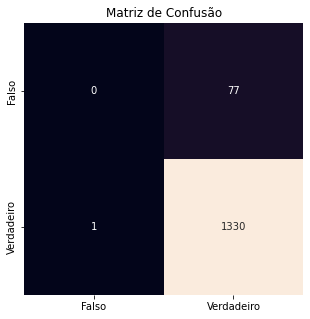

In [165]:
y_pred_teste_cnn_stem = teste_cnn(X_teste_loader_stem, y_teste_loader_stem, modelo_cnn_stem)
relatorio_matriz(y_teste_stem.tolist()[:len(y_pred_teste_cnn_stem)], y_pred_teste_cnn_stem)

A CNN preve quase sempre todas as classes como sendo *positivas*.

## LSTM

### Definição do Modelo

Na LSTM definimos dois modelos: um bidirecional e outro unidirecional.

In [352]:
class LstmAnaliseSentimento(nn.Module):
    
    def __init__(self, tam_max = corte, num_camadas = 2):
        
        super(LstmAnaliseSentimento, self).__init__()
        
        self.tam_max = tam_max
        self.num_layers = num_camadas
        
        self.lstm = nn.LSTM(input_size = 100,
                            hidden_size = self.tam_max,
                            num_layers = num_camadas,
                            #dropout = 0.2,
                            batch_first = True,
                            bidirectional = False
                           )
        
        self.dropout = nn.Dropout(0.4)
    
        self.linear = nn.Linear(self.tam_max, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):

        tam_batch = x.size(0) # tamanho do batch que ta sendo processado no momento
        
        x_lstm, hidden = self.lstm(x) # lstm
        
        x_cont = x_lstm.contiguous().view(-1, self.tam_max) # tensor contíguo 
        
        x_dropout = self.dropout(x_cont) # dropout
        
        x_linear = self.linear(x_dropout) # linear
        
        x_sigmoid = self.sigmoid(x_linear) # sigmoid
        
        x_remodelado = x_sigmoid.view(tam_batch, -1) # deixando do tamanho do batch
        
        x_ultimo = x_remodelado[:, -1] # lembrando que na lstm pega o último valor quando não é bidirecional
        
        return x_ultimo, hidden
    
    def iniciar_tensor_hidden(self, tam_batch):
        
        # Cria 2 tensores de tamanho num_camadas x batch_size x corte
        h0 = torch.zeros((self.num_layers, tam_batch, self.tam_max)).to(device)
        c0 = torch.zeros((self.num_layers, tam_batch, self.tam_max)).to(device)
        
        hidden = (h0, c0)
        
        return hidden

In [353]:
class LstmBidirecionalAnaliseSentimento(nn.Module):
    
    def __init__(self, tam_max = corte, num_camadas = 2):
        
        super(LstmBidirecionalAnaliseSentimento, self).__init__()
        
        self.tam_max = tam_max
        self.num_layers = num_camadas
        
        self.lstm = nn.LSTM(input_size = 100,
                            hidden_size = self.tam_max*2,
                            num_layers = num_camadas,
                            #dropout = 0.2,
                            batch_first = True,
                            bidirectional = True
                           )
        
        self.dropout = nn.Dropout(0.4)
    
        self.linear = nn.Linear(self.tam_max, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):

        tam_batch = x.size(0) # tamanho do batch que ta sendo processado
        
        x_lstm, hidden = self.lstm(x, hidden) # lstm
        
        x_cont = x_lstm.contiguous().view(-1, self.tam_max) # tensor contíguo 
        
        x_dropout = self.dropout(x_cont) # dropout
        
        x_linear = self.linear(x_dropout) # linear
        
        x_sigmoid = self.sigmoid(x_linear) # sigmoid
        
        x_remodelado = x_sigmoid.view(tam_batch, -1) # deixando do tamanho do batch

        meio = int(len(x_remodelado[0])/2)

        # lembrando que na lstm pega o último valor quando não é bidirecional
        # no nosso caso é bidirecional, então os 2 valores de interesse estarão no meio da saída
        x_ultimo = x_remodelado[:, (meio-1):(meio+1)]
        
        x_media = torch.mean(x_ultimo, dim = 1) # tirando a média do resultado direcional e bidirecional
        
        return x_media, hidden
    
    def iniciar_tensor_hidden(self, tam_batch):
        
        # Cria 2 tensores de tamanho num_camadas x batch_size x corte
        h0 = torch.zeros((self.num_layers*2, 32, self.tam_max*2)).to(device)
        c0 = torch.zeros((self.num_layers*2, 32, self.tam_max*2)).to(device)
        
        hidden = (h0, c0)
        
        return hidden

### Alocação do modelo e device adequado (dependente da disponibilidade da GPU)

In [366]:
# flag para escolher qual tipo de lstm vai utilizar
flag_bidirecional = False

if flag_bidirecional == True:
    modelo_lstm_tkn = LstmBidirecionalAnaliseSentimento()
    modelo_lstm_stem = LstmBidirecionalAnaliseSentimento()
else:
    modelo_lstm_tkn = LstmAnaliseSentimento()
    modelo_lstm_stem = LstmBidirecionalAnaliseSentimento()
    
# joga o modelo para GPU, caso aplicável
if usar_gpu == True:
    torch.cuda.init()
    cudnn.benchmark = True
    device = torch.device("cuda")
    modelo_lstm_tkn.cuda()
    modelo_lstm_stem.cuda()
else:
    device = torch.device("cpu")

In [367]:
print(modelo_lstm_tkn)

LstmAnaliseSentimento(
  (lstm): LSTM(100, 74, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=74, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Função de Custo e Otimizador

In [368]:
# função de custo (loss) adequada
criterio = nn.MSELoss()

# otimizador
otimizador_lstm_stem = torch.optim.Adam(modelo_lstm_stem.parameters(), lr = 0.001)
otimizador_lstm_tkn = torch.optim.Adam(modelo_lstm_tkn.parameters(), lr = 0.001)

### Treinamento e Validação

In [369]:
n_epocas = 5

#### Sem Pré-Processamento

In [370]:
treinamento_validacao_lstm(X_treino_loader_tkn, y_treino_loader_tkn,
                          X_valid_loader_tkn, y_valid_loader_tkn,
                          modelo_lstm_tkn, criterio, otimizador_lstm_tkn, n_epocas)

Epoca 1 	 Loss de Treinamento: 0.0021506724879145622
Epoca 1 	 Loss de Validação: 0.0016370867379009724

Epoca 2 	 Loss de Treinamento: 0.001630020560696721
Epoca 2 	 Loss de Validação: 0.0016048676334321499

Epoca 3 	 Loss de Treinamento: 0.0016330451471731067
Epoca 3 	 Loss de Validação: 0.0016207810258492827

Epoca 4 	 Loss de Treinamento: 0.001631493796594441
Epoca 4 	 Loss de Validação: 0.0016297140391543508

Epoca 5 	 Loss de Treinamento: 0.0016358805587515235
Epoca 5 	 Loss de Validação: 0.0016047944081947207



#### Com Stemming

In [371]:
treinamento_validacao_lstm(X_treino_loader_stem, y_treino_loader_stem,
                          X_valid_loader_stem, y_valid_loader_stem,
                          modelo_lstm_stem, criterio, otimizador_lstm_stem, n_epocas)

Epoca 1 	 Loss de Treinamento: 0.0018887761980295181
Epoca 1 	 Loss de Validação: 0.0016070482088252902

Epoca 2 	 Loss de Treinamento: 0.0016268512699753046
Epoca 2 	 Loss de Validação: 0.0016202208353206515

Epoca 3 	 Loss de Treinamento: 0.0016108736163005233
Epoca 3 	 Loss de Validação: 0.001624832977540791

Epoca 4 	 Loss de Treinamento: 0.001602647826075554
Epoca 4 	 Loss de Validação: 0.0016204628627747297

Epoca 5 	 Loss de Treinamento: 0.001612616702914238
Epoca 5 	 Loss de Validação: 0.001621426665224135



In [372]:
#melhor_modelo_lstm_tkn = torch.load('Checkpoints/LSTM/_modelo-epoca-5-perda-0.0035.pth', map_location = lambda storage, loc: storage)
#modelo_lstm_tkn.load_state_dict(melhor_modelo_lstm_tkn)

### Teste

#### Sem Pré-Processamento

Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     1.0000    0.0000    0.0000        77
    Positivo     0.9453    1.0000    0.9719      1331

    accuracy                         0.9453      1408
   macro avg     0.9727    0.5000    0.4859      1408
weighted avg     0.9483    0.9453    0.9187      1408



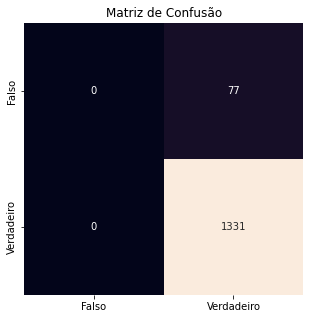

In [373]:
y_pred_teste_lstm_tkn = teste_lstm(X_teste_loader_tkn, y_teste_loader_tkn, modelo_lstm_tkn)
relatorio_matriz(y_teste.tolist()[:len(y_pred_teste_lstm_tkn)], y_pred_teste_lstm_tkn)

#### Com Stemming

Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     1.0000    0.0000    0.0000        77
    Positivo     0.9453    1.0000    0.9719      1331

    accuracy                         0.9453      1408
   macro avg     0.9727    0.5000    0.4859      1408
weighted avg     0.9483    0.9453    0.9187      1408



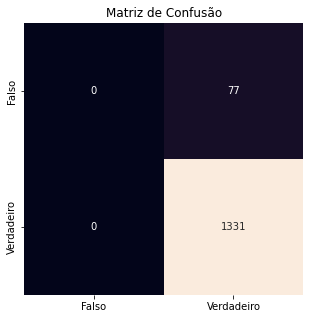

In [98]:
y_pred_teste_lstm_stem = teste_lstm(X_teste_loader_stem, y_teste_loader_stem, modelo_lstm_stem)
relatorio_matriz(y_teste.tolist()[:len(y_pred_teste_lstm_stem)], y_pred_teste_lstm_stem)

A LSTM prevê todos os reviews como sendo pertencentes a apenas uma classe, que é o *positivo*.

## BERT

### Funções Auxiliares

#### Formatação dos dados de entrada

In [99]:
def criar_dicionario(x_ids, mascara, tt_ids, rotulo):
    
    return {"input_ids": x_ids,
            "token_type_ids": tt_ids,
            "attention_mask": mascara,
           }, rotulo

In [100]:
def codificar_entrada_bert(X, y, tam_max):

    X_ids = []
    tt_ids = []
    mascara = []
    classes = []

    for texto, classe in zip(X, y):

        bert_input = formatar_entrada_bert(texto, tam_max)
        X_ids.append(bert_input['input_ids'])
        tt_ids.append(bert_input['token_type_ids'])
        mascara.append(bert_input['attention_mask'])
        classes.append([classe])

    return tf.data.Dataset.from_tensor_slices((X_ids, mascara, tt_ids, classes)).map(criar_dicionario)

#### Funções de Teste

In [101]:
def teste_encoder_entrada(texto, tam_max):
    
    predict_input = tokenizer.encode(texto,
                                     truncation = True,
                                     max_length = tam_max,
                                     padding = True,
                                     return_tensors = "tf")
    
    return predict_input

In [102]:
def teste(texto, tam_max, modelo_bert):
    
    entrada = teste_encoder_entrada(texto, tam_max)
        
    y_pred = modelo_bert.predict(entrada)[0]
    
    entrada_softmax = tf.nn.softmax(y_pred, axis = 1)
    
    return tf.argmax(entrada_softmax, axis = 1).numpy()[0]

### Formatando a Entrada

Asssim como fizemos anteriormente, vamos preparar os dados que serão utilizados como entrada do BERT.

A função abaixo vai tokenizar o texto de entrada, adicionar os paddings e padronizar a entrada para um tamanho igual a *tam_max* (a variável *corte* que definimos lá no ínicio).

In [103]:
def formatar_entrada_bert(texto, tam_max):

    return tokenizer.encode_plus(texto,
                                 add_special_tokens = True, # adiciona [CLS], [SEP]
                                 max_length = tam_max, # comprimento máximo do texto de entrada
                                 padding = 'max_length', # adiciona [PAD] até o tam_max
                                 truncation = True, # padrão = 'longest_first'
                                 return_attention_mask = True, # adiciona máscara de atenção para não focar nos tokens do pad
                                )

Primeiro vamos construir um [`tokenizador BERT`](https://huggingface.co/docs/transformers/model_doc/bert).

In [104]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case = False)

#### Separando o Dataset de Novo

In [105]:
tam_batch = 1

##### Sem Pré-Processamento

In [106]:
if flag_bert == True:
    
    X_treino_bert_tkn = df['Review'][X_treino.index.tolist()].tolist()
    X_valid_bert_tkn = df['Review'][X_valid.index.tolist()].tolist()
    X_teste_bert_tkn = df['Review'][X_teste.index.tolist()].tolist()
    
    y_treino_bert_tkn = df['classe'][y_treino.index.tolist()].tolist()
    y_valid_bert_tkn = df['classe'][y_valid.index.tolist()].tolist()
    y_teste_bert_tkn = df['classe'][y_teste.index.tolist()].tolist()
    
    X_y_treino_encoded_tkn = codificar_entrada_bert(X_treino_bert_tkn, y_treino_bert_tkn, corte).shuffle(10000).batch(tam_batch)
    X_y_valid_encoded_tkn = codificar_entrada_bert(X_valid_bert_tkn, y_valid_bert_tkn, corte).batch(tam_batch)

##### Com Stemming

In [107]:
if flag_bert == True:
    
    X_treino_bert_stem = df['stemming'][X_treino_stem.index.tolist()].tolist()
    X_valid_bert_stem = df['stemming'][X_valid_stem.index.tolist()].tolist()
    X_teste_bert_stem = df['stemming'][X_teste_stem.index.tolist()].tolist()
    
    y_treino_bert_stem = df['classe'][y_treino_stem.index.tolist()].tolist()
    y_valid_bert_stem = df['classe'][y_valid_stem.index.tolist()].tolist()
    y_teste_bert_stem = df['classe'][y_teste_stem.index.tolist()].tolist()
    
    X_y_treino_encoded_stem = codificar_entrada_bert(X_treino_bert_stem, y_treino_bert_stem, corte).shuffle(10000).batch(tam_batch)
    X_y_valid_encoded_stem = codificar_entrada_bert(X_valid_bert_stem, y_valid_bert_stem, corte).batch(tam_batch)

### Otimizador e Inicialização do Modelo

In [108]:
# otimizador
lr = 2e-5 # recommended learning rate for Adam 5e-5, 3e-5, 2e-5
otimizador_bert = Adam(learning_rate = lr, epsilon = 1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
perda_bert = SparseCategoricalCrossentropy(from_logits = True)

metrica_bert = SparseCategoricalAccuracy('accuracy')

In [109]:
if flag_bert == True:
    
    modelo_bert_tkn = TFBertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', from_pt = True)
    modelo_bert_stem = TFBertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', from_pt = True)
    
    modelo_bert_tkn.compile(optimizer = otimizador_bert, loss = perda_bert, metrics = [metrica_bert])
    modelo_bert_stem.compile(optimizer = otimizador_bert, loss = perda_bert, metrics = [metrica_bert])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Calculando os parâmetros de aprendizagem do BERT

In [110]:
n_epocas = 10

#### Sem Pré-Processamento

In [111]:
if flag_bert == True:
    
    bert_hist_tkn = modelo_bert_tkn.fit(X_y_treino_encoded_tkn, epochs = n_epocas, validation_data = X_y_valid_encoded_tkn)

Epoch 1/10
3997/3997 [==============================] - 2321s 578ms/step - loss: 0.1183 - accuracy: 0.9562 - val_loss: 0.0917 - val_accuracy: 0.9691
Epoch 2/10
3997/3997 [==============================] - 2302s 576ms/step - loss: 0.0737 - accuracy: 0.9747 - val_loss: 0.0994 - val_accuracy: 0.9650
Epoch 3/10
3997/3997 [==============================] - 2308s 577ms/step - loss: 0.0500 - accuracy: 0.9837 - val_loss: 0.0973 - val_accuracy: 0.9650
Epoch 4/10
3997/3997 [==============================] - 2299s 575ms/step - loss: 0.0381 - accuracy: 0.9900 - val_loss: 0.1869 - val_accuracy: 0.9621
Epoch 5/10
3997/3997 [==============================] - 2302s 576ms/step - loss: 0.0438 - accuracy: 0.9900 - val_loss: 0.1823 - val_accuracy: 0.9621
Epoch 6/10
3997/3997 [==============================] - 2305s 577ms/step - loss: 0.0356 - accuracy: 0.9925 - val_loss: 0.1821 - val_accuracy: 0.9656
Epoch 7/10
3997/3997 [==============================] - 2314s 579ms/step - loss: 0.0391 - accuracy: 0.9887

#### Com Stemming

In [112]:
if flag_bert == True:
    
    bert_hist_stem = modelo_bert_stem.fit(X_y_treino_encoded_stem, epochs = n_epocas, validation_data = X_y_valid_encoded_stem)

Epoch 1/10
3997/3997 [==============================] - 2406s 599ms/step - loss: 0.2040 - accuracy: 0.9496 - val_loss: 0.1866 - val_accuracy: 0.9451
Epoch 2/10
3997/3997 [==============================] - 2320s 580ms/step - loss: 0.1298 - accuracy: 0.9547 - val_loss: 0.1700 - val_accuracy: 0.9451
Epoch 3/10
3997/3997 [==============================] - 2390s 598ms/step - loss: 0.1305 - accuracy: 0.9490 - val_loss: 0.1652 - val_accuracy: 0.9451
Epoch 4/10
3997/3997 [==============================] - 2336s 584ms/step - loss: 0.1273 - accuracy: 0.9467 - val_loss: 0.1575 - val_accuracy: 0.9451
Epoch 5/10
3997/3997 [==============================] - 2394s 599ms/step - loss: 0.1637 - accuracy: 0.9457 - val_loss: 0.2130 - val_accuracy: 0.9451
Epoch 6/10
3997/3997 [==============================] - 2343s 586ms/step - loss: 0.1950 - accuracy: 0.9485 - val_loss: 0.2004 - val_accuracy: 0.9475
Epoch 7/10
3997/3997 [==============================] - 2421s 606ms/step - loss: 0.1591 - accuracy: 0.9425

### Teste

#### Sem Pré-Processamento

In [113]:
if flag_bert == True:
    
    y_teste_bert_pred_tnk = df['Review'][X_teste.index.tolist()].progress_apply(lambda linha: teste(linha, corte, modelo_bert_tkn)).tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 1428/1428 [01:45<00:00, 13.51it/s]


Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     0.6484    0.7564    0.6982        78
    Positivo     0.9858    0.9763    0.9810      1350

    accuracy                         0.9643      1428
   macro avg     0.8171    0.8664    0.8396      1428
weighted avg     0.9674    0.9643    0.9656      1428



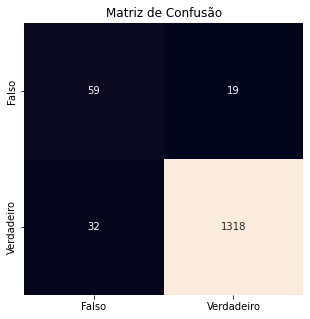

In [118]:
if flag_bert == True:
    
    relatorio_matriz(y_teste_bert_tkn, y_teste_bert_pred_tnk)

#### Com Stemming

In [115]:
if flag_bert == True:
    
    y_teste_bert_pred_stem = df['stemming'][X_teste.index.tolist()].progress_apply(lambda linha: teste(linha, corte, modelo_bert_stem)).tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 1428/1428 [01:48<00:00, 13.19it/s]


Relatório de classificação:
               precision    recall  f1-score   support

    Negativo     0.5682    0.3205    0.4098        78
    Positivo     0.9617    0.9859    0.9737      1350

    accuracy                         0.9496      1428
   macro avg     0.7649    0.6532    0.6918      1428
weighted avg     0.9402    0.9496    0.9429      1428



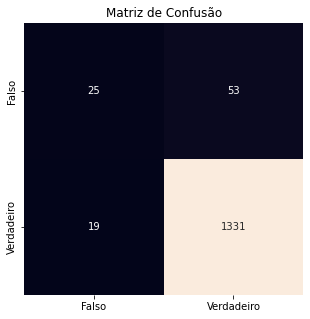

In [119]:
if flag_bert == True:
    
    relatorio_matriz(y_teste_bert_stem, y_teste_bert_pred_stem, digitos = 4)

Dos modelos implementados neste notebook, o BERT foi o que apresentou os melhores resultados. Sendo que, o BERT treinado sem o pré-processamento do texto teve de forma geral, previsões mais precisas no teste do que o BERT treinado utilizando o stemming.

Seguido pelo RF-BoW que teve a *precisão* e o *f1-score* maiores para o texto sem pré-processamento.

E em último lugar a CNN e a LSTM que tiveram um desempenho muito similar para os dois tipos de pré-processamento de texto, ambas prevendo quase sempre a classe como *positivo*, fazendo com que o *recall* e o *f1-score* da classe *negativa* desse 0.